## Chapter 4: Optimization Modeling

This chapter focuses on how to optimize a revenue function subject to constraints

Toy Example 1: Guns + Butter

195 dollars for every machine gun you sell
150 for every ton of butter you sell

Constraints:
100 to produce a ton of butter
150 produce a machine gun
Budget = 1800

Store is 21 m^3
Guns take up 0.5 m^3
and butter take up 1.5 m^3


This can be solved through linear programming given all relationships can be express in linear terms.

Can't do conditionals / multiplying decisions together, otherwise it becomes non-linear

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### First let's try to graph our constraints

Budget Constraint
100 * B + 150 * G = 1800
150G = 1800 - 100B
G = 12 - 2/3B

Space Constraint
0.5 * G + 1.5 B = 21
G = -3B + 42

Both of these together define a region of possible solutions, what you can actuall make

### Introducing the Level Set - region iwhere all the points give the sam revenue, so you fix R
195 + G + 150 B = R
G = (R / 195) - (150 / 195)B

In [2]:
def produce_level_set(sample_b, r=1950):
    return (r / 195) - (150 / 195) * sample_b

## You can see we want to push the level-set out as far as possible to hit its a corner, since this will enusre we maximize revenue while adhereing to constraint. The math is beyond the scope but intuitively if you go further it's not possible (no longer touching budget constraint reason), if you move in inward you have reduced R so you are not maximizing revenue

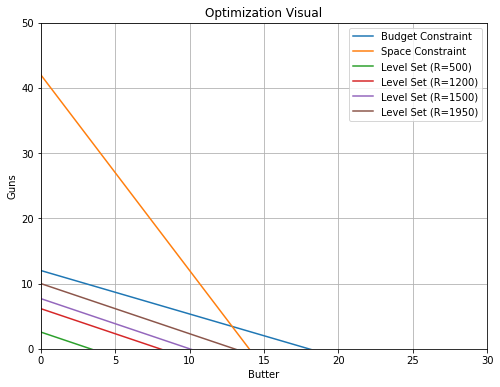

In [3]:
plt.figure(num=None, figsize=(8, 6))

b = np.linspace(0,25,100)
budget_g = 12 - (2 / 3) * b
space_g = 42 - 3 * b
plt.plot(b, budget_g, label='Budget Constraint')
plt.plot(b, space_g,  label='Space Constraint')
for level in [500, 1200, 1500, 1950]:
    plt.plot(b, produce_level_set(b, r=level), label='Level Set (R={})'.format(level))
plt.title('Optimization Visual')
plt.xlabel('Butter')
plt.ylabel('Guns')
plt.legend(loc='best')
plt.ylim(0, 50)
plt.xlim(0, 30)
plt.grid()
plt.show()

The algorithm decision to find corners is simplex, it basically looks for corners in your budget reason and
finds the one that maximizes rev, easier than searching infinite number of points in reegion


In [4]:
# Notes about this: expects <= constrains and minimizes the function, so take negative in order to maximize
from scipy.optimize import linprog

In [5]:
# revenue = 150 * B + 195G
# Note its expects <= but can always multiple by -1 to get >= and cna put in both to get equal to
fxn_to_maximize = [-150, -195]
constraints_left_hand_side = [[100, 150], [1.5, 0.5]]
constrains_ride_hand_side = [1800, 21]
linprog(
    fxn_to_maximize,
    constraints_left_hand_side,
    constrains_ride_hand_side
)

     con: array([], dtype=float64)
     fun: -2597.1428433332135
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([9.48400043e-06, 1.17972505e-07])
  status: 0
 success: True
       x: array([12.85714278,  3.42857141])

Yields 12.9 butter and 3.42 buns but this obv don't make sense since you need integer outp ut (can't make 3.42 guns. This would have yielded -2597 in revenue

####  Unfortunately integer linear programming which makes the problme a lot tougher isn't supported by numpy, going to go to pulp library

https://pypi.org/project/PuLP/

In [6]:
from pulp import LpProblem, LpMaximize, LpMinimize, LpVariable, value

In [7]:
def solve_using_pulp(guns, butter):
    prob = LpProblem("guns_and_butter", LpMaximize)
    # Add Constraints
    prob += 100 * butter + 150 * guns <= 1800
    prob += 1.5 * butter + 0.5 * guns <= 21
    # If you add an expression (not a constraint), it will become the objective:
    prob += 150 * butter + 195 * guns
    status = prob.solve()
    print("Optimal value of guns: ", value(guns))
    print("Optimal value of butter: ",value(butter))
    print("Revenue", prob.objective.value())

In [8]:
# First Use Continous Guns and Butter
guns = LpVariable("g")
butter = LpVariable("b")
solve_using_pulp(guns, butter)

Optimal value of guns:  3.4285714
Optimal value of butter:  12.857143
Revenue 2597.1428730000002


## So I replicated but now going to do putting integer constraint

In [9]:
guns = LpVariable("g", cat="Integer")
butter = LpVariable("b", cat="Integer")
solve_using_pulp(guns, butter)

Optimal value of guns:  4.0
Optimal value of butter:  12.0
Revenue 2580.0


## Now going to use data-set related to optimization problems around orange juice production

In [10]:
excel_file_obj = pd.ExcelFile("../raw_data/OrangeJuiceBlending.xlsx")
specs = pd.read_excel(excel_file_obj, "Specs")

### Specs on different type of juicd, whatever you choose to buy will be shipped to blending facility in FL which is why shipping cost from FL is 0

In [11]:
specs.loc[:, "total_cost"] = specs.loc[:, "Price (per 1K Gallons)"] + specs.loc[:, "Shipping"]
# Need to make sure pandas know thiis is a pct
specs.loc[:, "Acid (%)"] = specs.loc[:, "Acid (%)"] * 100
specs.head(20)

,Varietal,Region,"Qty Available (1,000 Gallons)",Brix / Acid Ratio,Acid (%),Astringency (1-10 Scale),Color (1-10 Scale),Price (per 1K Gallons),Shipping,total_cost
0,Hamlin,Brazil,672,10.5,0.60,3,3,500,100,600
1,Mosambi,India,400,6.5,1.40,7,1,310,150,460
2,Valencia,Florida,1200,12.0,0.95,3,3,750,0,750
3,Hamlin,California,168,11.0,1.00,3,5,600,60,660
4,Gardner,Arizona,84,12.0,0.70,1,5,600,75,675
5,Sunstar,Texas,210,10.0,0.70,1,5,625,50,675
6,Jincheng,China,588,9.0,1.35,7,3,440,120,560
7,Berna,Spain,168,15.0,1.10,4,8,600,110,710
8,Verna,Mexico,300,8.0,1.30,8,3,300,90,390
9,Biondo Commune,Egypt,210,13.0,1.30,3,5,460,130,590


In [12]:
# Hamlin repeats will lead to bugs
specs.iloc[0, 0] = "bhamlin"

In [13]:
specs.head()

,Varietal,Region,"Qty Available (1,000 Gallons)",Brix / Acid Ratio,Acid (%),Astringency (1-10 Scale),Color (1-10 Scale),Price (per 1K Gallons),Shipping,total_cost
0,bhamlin,Brazil,672,10.5,0.60,3,3,500,100,600
1,Mosambi,India,400,6.5,1.40,7,1,310,150,460
2,Valencia,Florida,1200,12.0,0.95,3,3,750,0,750
3,Hamlin,California,168,11.0,1.00,3,5,600,60,660
4,Gardner,Arizona,84,12.0,0.70,1,5,600,75,675


### Here are you orders:

Lowest Cost Purchase pPlan for Jan, Feb, Mar that meet demand of 600k gallons in Jan and Feb and 700k in Mar

Company needs to buy at least 40% of juice from FL to get tax incentives from state of FL

Brix / Acid ratio must stay between 11.5 and 12.5

Acid Level between 0.75 and 1 percent

Astringency must be 4 or lower

Color must remain between 4.5 and 5.5

In [14]:
jan_demand = 600
feb_demand = 600
mar_demand = 700
tax_pct_requirement = 0.4

fl_jan_requirement = 0.4 * jan_demand
fl_feb_requirement = 0.4 * feb_demand
fl_mar_requirement = 0.4 * mar_demand

Basically I have to create a variable $prod_{ij}$ which is orders of juice i in month j

j in (1-3)

i(0-9)

In [15]:
# Set up data structures to make problem easier
juice_lists = specs["Varietal"].tolist()

costs = dict(zip(juice_lists, specs["total_cost"]))
brix = dict(zip(juice_lists, specs["Brix / Acid Ratio"]))
acid = dict(zip(juice_lists, specs["Acid (%)"]))
color = dict(zip(juice_lists, specs["Color (1-10 Scale)"]))
astrigency = dict(zip(juice_lists, specs["Astringency (1-10 Scale)"]))


availability = dict(zip(juice_lists, specs["Qty Available (1,000 Gallons)"]))

In [16]:
costs

{'bhamlin': 600,
 'Mosambi': 460,
 'Valencia': 750,
 'Hamlin': 660,
 'Gardner': 675,
 'Sunstar': 675,
 'Jincheng': 560,
 'Berna': 710,
 'Verna': 390,
 'Biondo Commune': 590,
 'Belladonna': 620}

In [17]:
def transform_into_one_for_each_month(dict_one_per_juice: dict) -> dict:
    new_dict = {}
    for k, v in dict_one_per_juice.items():
        for mon in range(1, 4):
            new_dict["{}_{}".format(k, mon)] = v
    return new_dict

In [18]:
def transform_list_into_one_for_each_month(list_for_each_juice: list) -> list:
    return ["{}_{}".format(juice, mon) for juice in list_for_each_juice for mon in range(1, 4)]

In [19]:
full_juice_list = transform_list_into_one_for_each_month(juice_lists)

In [20]:
full_juice_list

['bhamlin_1',
 'bhamlin_2',
 'bhamlin_3',
 'Mosambi_1',
 'Mosambi_2',
 'Mosambi_3',
 'Valencia_1',
 'Valencia_2',
 'Valencia_3',
 'Hamlin_1',
 'Hamlin_2',
 'Hamlin_3',
 'Gardner_1',
 'Gardner_2',
 'Gardner_3',
 'Sunstar_1',
 'Sunstar_2',
 'Sunstar_3',
 'Jincheng_1',
 'Jincheng_2',
 'Jincheng_3',
 'Berna_1',
 'Berna_2',
 'Berna_3',
 'Verna_1',
 'Verna_2',
 'Verna_3',
 'Biondo Commune_1',
 'Biondo Commune_2',
 'Biondo Commune_3',
 'Belladonna_1',
 'Belladonna_2',
 'Belladonna_3']

In [21]:
costs_for_each_month = transform_into_one_for_each_month(costs)
color_for_each_month = transform_into_one_for_each_month(color)
acid_for_each_month = transform_into_one_for_each_month(acid)
astrigency_for_each_month = transform_into_one_for_each_month(astrigency)
brix_for_each_month = transform_into_one_for_each_month(brix)

In [22]:
costs_for_each_month

{'bhamlin_1': 600,
 'bhamlin_2': 600,
 'bhamlin_3': 600,
 'Mosambi_1': 460,
 'Mosambi_2': 460,
 'Mosambi_3': 460,
 'Valencia_1': 750,
 'Valencia_2': 750,
 'Valencia_3': 750,
 'Hamlin_1': 660,
 'Hamlin_2': 660,
 'Hamlin_3': 660,
 'Gardner_1': 675,
 'Gardner_2': 675,
 'Gardner_3': 675,
 'Sunstar_1': 675,
 'Sunstar_2': 675,
 'Sunstar_3': 675,
 'Jincheng_1': 560,
 'Jincheng_2': 560,
 'Jincheng_3': 560,
 'Berna_1': 710,
 'Berna_2': 710,
 'Berna_3': 710,
 'Verna_1': 390,
 'Verna_2': 390,
 'Verna_3': 390,
 'Biondo Commune_1': 590,
 'Biondo Commune_2': 590,
 'Biondo Commune_3': 590,
 'Belladonna_1': 620,
 'Belladonna_2': 620,
 'Belladonna_3': 620}

Next we start to formulate the problem

In [23]:
def get_correct_constraint_avg_metric(prob, metrics_array, month_number, max_value, min_value):
    """We wan to make sure the avg of a metrics (weighted by orders) follows under a min max constraint
       Here we divide by demand not orders because dividing by demand keeps it linear. Since we set output =
       demand this works"""
    if month_number == 1:
        demand = jan_demand
    elif month_number == 2:
        demand = feb_demand
    else:
        demand = mar_demand
    metrics_array_product = [metrics_array[j] * juice_orders[j] for j in full_juice_list if str(month_number) in j]
    prob += lpSum(metrics_array_product) / demand <= max_value
    prob += lpSum(metrics_array_product) / demand >= min_value
    return prob

In [24]:
from pulp import lpSum, LpStatus, LpMinimize
prob = LpProblem("minimize_cost", LpMinimize)
juice_orders = LpVariable.dicts(
    "Juice_Orders",
    full_juice_list,
    lowBound=0)

# Have to make sure you meet demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "1" in j]) >= jan_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "1" in j]) <= jan_demand

prob += lpSum([juice_orders[j] for j in full_juice_list if "2" in j]) >= feb_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "2" in j]) <= feb_demand

prob += lpSum([juice_orders[j] for j in full_juice_list if "3" in j]) >= mar_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "3" in j]) <= mar_demand

# Have to make sure that you meet FL requirement
prob += juice_orders["Valencia_1"] >= fl_jan_requirement
prob += juice_orders["Valencia_2"] >= fl_feb_requirement
prob += juice_orders["Valencia_3"] >= fl_mar_requirement
# Availability - make sure sum of all 3 <= total availability
# So Valencia_1 + Valencia_2 + Valencia 3
for juice_name in juice_lists:
    prob += lpSum([juice_orders[juice_nam_var] for juice_nam_var in full_juice_list 
                   if juice_name in juice_nam_var]) <= availability[juice_name]

# Brix 
for month_number in range(1, 4):
    # Brix
    prob = get_correct_constraint_avg_metric(
        prob=prob,
        metrics_array=brix_for_each_month,
        month_number=month_number,
        max_value=12.5,
        min_value=11.5
    )
    # Acid
    prob = get_correct_constraint_avg_metric(
        prob=prob,
        metrics_array=acid_for_each_month,
        month_number=month_number,
        max_value=1,
        min_value=0.75
    )
    # Color
    prob = get_correct_constraint_avg_metric(
        prob=prob,
        metrics_array=color_for_each_month,
        month_number=month_number,
        max_value=5.5,
        min_value=4.5
    )
    # astrigency
    prob = get_correct_constraint_avg_metric(
        prob=prob,
        metrics_array=astrigency_for_each_month,
        month_number=month_number,
        max_value=4,
        min_value=1
    ) 
# Last put in actual objective function
prob += lpSum([juice_orders[j] * costs_for_each_month[j] for j in full_juice_list])

In [25]:
status = prob.solve()
print(LpStatus[status])
print("Minimal Cost", prob.objective.value() / 1000000)

Optimal
Minimal Cost 1.2275600025800004


This matches the book of 1.23 million to produce this

In [26]:
for i in juice_orders:
    print(i, value(juice_orders[i]))

bhamlin_1 0.0
bhamlin_2 0.0
bhamlin_3 0.0
Mosambi_1 0.0
Mosambi_2 13.5
Mosambi_3 0.0
Valencia_1 240.0
Valencia_2 240.0
Valencia_3 280.0
Hamlin_1 111.16667
Hamlin_2 0.0
Hamlin_3 0.0
Gardner_1 23.008435
Gardner_2 42.570513
Gardner_3 18.421053
Sunstar_1 0.0
Sunstar_2 73.333333
Sunstar_3 0.0
Jincheng_1 0.0
Jincheng_2 0.0
Jincheng_3 0.0
Berna_1 28.961538
Berna_2 139.03846
Berna_3 0.0
Verna_1 61.073887
Verna_2 91.557692
Verna_3 147.36842
Biondo Commune_1 81.973684
Biondo Commune_2 0.0
Biondo Commune_3 128.02632
Belladonna_1 53.815789
Belladonna_2 0.0
Belladonna_3 126.18421


In [27]:
print("Minimal Cost", prob.objective.value() / 1000000)

Minimal Cost 1.2275600025800004


### New Problem Manager wants you to cut costs by 5% which is rouglly .06 million, so make it so that the cost is 1.17 million

### New Formulation of Problem
Now Cost isn't the objective to minimize, it's value that has to be <= 1.17 million

Instead we relax quality on:
 - color
 - acidity
 - astrigency_for_each_month
 - acid
 
 What we do is we say we introduce %quality_relax (% Quality Relax on Acid for Example) and define
 
 new_acid_min = old_acid_min - % Quality Relax on Acid * (old acid max - old acid min)
 so if old acid was 0.75 - 1
 
 and % quality is 10 %
 
 new_acid_min = 0.75 - 0.1 * (1 - 0.75)
 
 new_acid_min = 0.75 - .025
 
 new_acid_min = 0.725
 
 Our goal is minimize % Quality Relaxation on these 4 vars
 

In [28]:
taste_list = ["brix", "acid", "color", "astrigency"]

In [29]:
def put_in_taste_constraints(prob, metrics_array, month_number, max_value, min_value, name):
    """Similiar to before but now I am putting in a new min value where the new min value is a function
       of new taste quality drop variables where the new objective is to minimize the drop in quality"""
    if month_number == 1:
        demand = jan_demand
    elif month_number == 2:
        demand = feb_demand
    else:
        demand = mar_demand
    metrics_array_product = [metrics_array[j] * juice_orders[j] for j in full_juice_list if str(month_number) in j]
    # new_min / new_max = old_value +/- quality * (old_max - old_min)
    max_minus_min_times_quality = (max_value - min_value) * taste_orders[name]
    prob += lpSum(metrics_array_product) / demand <= max_value + max_minus_min_times_quality
    prob += lpSum(metrics_array_product) / demand >= min_value - max_minus_min_times_quality   
    return prob

In [30]:

from pulp import lpSum, LpStatus
prob = LpProblem("minimize_cost",LpMinimize)
juice_orders = LpVariable.dicts(
    "Juice_Orders",
    full_juice_list,
    lowBound=0)

taste_orders = LpVariable.dicts(
    "Taste Orders",
    taste_list,
    lowBound=0,
    upBound=1
)

# Have to make sure you meet demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "1" in j]) >= jan_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "1" in j]) <= jan_demand

prob += lpSum([juice_orders[j] for j in full_juice_list if "2" in j]) >= feb_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "2" in j]) <= feb_demand

prob += lpSum([juice_orders[j] for j in full_juice_list if "3" in j]) >= mar_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "3" in j]) <= mar_demand

# Have to make sure that you meet FL requirement
prob += juice_orders["Valencia_1"] >= fl_jan_requirement
prob += juice_orders["Valencia_2"] >= fl_feb_requirement
prob += juice_orders["Valencia_3"] >= fl_mar_requirement
# Availability - make sure sum of all 3 <= total availability
# So Valencia_1 + Valencia_2 + Valencia 3
for juice_name in juice_lists:
    prob += lpSum([juice_orders[juice_nam_var] for juice_nam_var in full_juice_list 
                   if juice_name in juice_nam_var]) <= availability[juice_name]


# Brix 
for month_number in range(1, 4):
    # Brix
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=brix_for_each_month,
        month_number=month_number,
        max_value=12.5,
        min_value=11.5,
        name="brix"
    )
    # Acid
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=acid_for_each_month,
        month_number=month_number,
        max_value=1,
        min_value=0.75,
        name="acid"
    )
    # Color
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=color_for_each_month,
        month_number=month_number,
        max_value=5.5,
        min_value=4.5,
        name="color"
    )
    # astrigency
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=astrigency_for_each_month,
        month_number=month_number,
        max_value=4,
        min_value=1,
        name="astrigency"
    ) 
# New Cost Constraint from the manager 
prob += lpSum([juice_orders[j] * costs_for_each_month[j] for j in full_juice_list]) <= 1170000
# Going to minize Quality Deviation
prob += lpSum([taste_orders[taste] for taste in taste_list]) / len(taste_list)

In [31]:
status = prob.solve()
print(LpStatus[status])
print("Quality Reduction", prob.objective.value() )

Optimal
Quality Reduction 0.35138241375


### So we get with average reduction of 37% we can achieve the new cost constraint - going to skip the plot trade off, but yeah could vary cost constraint and get different cost tradeoffs

In [32]:
#Problem with above
print("Color Change Change", value(taste_orders["color"]))
print("Brix Change", value(taste_orders["brix"]))
print("Acid Change", value(taste_orders["acid"]))
print("Astrigency Change", value(taste_orders["astrigency"]))

Color Change Change 0.83744171
Brix Change 0.50846103
Acid Change 0.0
Astrigency Change 0.059626915


In this case what we want to do is minimize the maximum since 37 isn't bad, but one is almost 60% reduced

But if you try to minimize the Max(Trade Quality % Changes) that's non-linear

Key Question: how do this in a linear way

#### Now going to minimize, "taste_all" where all of the other taste quality differences have to be less than or equal to that, so it will look to minimize the new quanity while bringing the others down with it

In [33]:
from pulp import lpSum, LpStatus
prob = LpProblem("minimize_cost",LpMinimize)
juice_orders = LpVariable.dicts(
    "Juice_Orders",
    full_juice_list,
    lowBound=0
)
    #cat="Integer")

taste_orders = LpVariable.dicts(
    "Taste Orders",
    taste_list,
    lowBound=0,
    upBound=1
)
all_taste = LpVariable("all", lowBound=0, upBound=1)


# Have to make sure you meet demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "1" in j]) >= jan_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "1" in j]) <= jan_demand

prob += lpSum([juice_orders[j] for j in full_juice_list if "2" in j]) >= feb_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "2" in j]) <= feb_demand

prob += lpSum([juice_orders[j] for j in full_juice_list if "3" in j]) >= mar_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "3" in j]) <= mar_demand

# Have to make sure that you meet FL requirement
prob += juice_orders["Valencia_1"] >= fl_jan_requirement
prob += juice_orders["Valencia_2"] >= fl_feb_requirement
prob += juice_orders["Valencia_3"] >= fl_mar_requirement
# Availability - make sure sum of all 3 <= total availability
# So Valencia_1 + Valencia_2 + Valencia 3
for juice_name in juice_lists:
    prob += lpSum([juice_orders[juice_nam_var] for juice_nam_var in full_juice_list 
                   if juice_name in juice_nam_var]) <= availability[juice_name]


# Brix 
for month_number in range(1, 4):
    # Brix
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=brix_for_each_month,
        month_number=month_number,
        max_value=12.5,
        min_value=11.5,
        name="brix"
    )
    # Acid
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=acid_for_each_month,
        month_number=month_number,
        max_value=1,
        min_value=0.75,
        name="acid"
    )
    # Color
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=color_for_each_month,
        month_number=month_number,
        max_value=5.5,
        min_value=4.5,
        name="color"
    )
    # astrigency
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=astrigency_for_each_month,
        month_number=month_number,
        max_value=4,
        min_value=1,
        name="astrigency"
    ) 
prob += lpSum([juice_orders[j] * costs_for_each_month[j] for j in full_juice_list]) <= 1170000
# Next Add
for t in taste_list:
    prob += taste_orders[t] <= all_taste


# Going to minize Quality Deviation
prob += lpSum(all_taste)
prob

minimize_cost:
MINIMIZE
1*all + 0
SUBJECT TO
_C1: Juice_Orders_Belladonna_1 + Juice_Orders_Berna_1
 + Juice_Orders_Biondo_Commune_1 + Juice_Orders_Gardner_1
 + Juice_Orders_Hamlin_1 + Juice_Orders_Jincheng_1 + Juice_Orders_Mosambi_1
 + Juice_Orders_Sunstar_1 + Juice_Orders_Valencia_1 + Juice_Orders_Verna_1
 + Juice_Orders_bhamlin_1 >= 600

_C2: Juice_Orders_Belladonna_1 + Juice_Orders_Berna_1
 + Juice_Orders_Biondo_Commune_1 + Juice_Orders_Gardner_1
 + Juice_Orders_Hamlin_1 + Juice_Orders_Jincheng_1 + Juice_Orders_Mosambi_1
 + Juice_Orders_Sunstar_1 + Juice_Orders_Valencia_1 + Juice_Orders_Verna_1
 + Juice_Orders_bhamlin_1 <= 600

_C3: Juice_Orders_Belladonna_2 + Juice_Orders_Berna_2
 + Juice_Orders_Biondo_Commune_2 + Juice_Orders_Gardner_2
 + Juice_Orders_Hamlin_2 + Juice_Orders_Jincheng_2 + Juice_Orders_Mosambi_2
 + Juice_Orders_Sunstar_2 + Juice_Orders_Valencia_2 + Juice_Orders_Verna_2
 + Juice_Orders_bhamlin_2 >= 600

_C4: Juice_Orders_Belladonna_2 + Juice_Orders_Berna_2
 + Juice_O

In [34]:
status = prob.solve()
print(LpStatus[status])
print("Quality Reduction", prob.objective.value() )

Optimal
Quality Reduction 0.58736842


In [35]:
print("Color Change Change", value(taste_orders["color"]))
print("Brix Change", value(taste_orders["brix"]))
print("Acid Change", value(taste_orders["acid"]))
print("Astrigency Change", value(taste_orders["astrigency"]))

Color Change Change 0.58736842
Brix Change 0.51425101
Acid Change 0.32926316
Astrigency Change 0.22982456


### If-then and the the Big M

Now what if your supply chain team says they want a limit of no more than 4 suppliers on any given month

Need a way to introduce variables that come on when orders > 1

We are going back to the original minimizng ocst problem (with original quality constraint) but now we are going to only allow 4 regions.

How do you program a binary indicator variable without introducing non-linearity

For each juide introduce a new Variable called Ordered_j.

Set Ordered_j >= Quanity_j

problem though is that Sum of all Ordered_j <= 4

So you need sum way of limiting the Ordered Vars while allowing Quantity to be large

You use "Big-M" - just a large number that ensures left hand of the equation will alwas be >= Quanity
in this case we will use avaiability
so 
Availability_j * Ordered_j >= Quantity_j

Ex Hamlin:
672 * ordered_hamlin >= quantity_hamlin

Always goign to restrict them to be upper bound 1


In [36]:
# Going back to original Cost Minimization Problem
prob = LpProblem("minimize_cost", LpMinimize)
juice_orders = LpVariable.dicts(
    "Juice_Orders",
    full_juice_list,
    lowBound=0
)
juice_binary = LpVariable.dicts(
    "Juice_Binary",
    full_juice_list,
    lowBound=0,
    cat="Integer"
)

# Make sure they are binary
for juice_name in full_juice_list:
    prob += juice_binary[juice_name] <= 1

# Make sure Each Month Sums to 4
prob += lpSum([juice_binary[j] for j in full_juice_list if "1" in j]) <= 4
prob += lpSum([juice_binary[j] for j in full_juice_list if "2" in j]) <= 4
prob += lpSum([juice_binary[j] for j in full_juice_list if "3" in j]) <= 4

# Put in Big M Constraints
for juice_name in full_juice_list:
    availability_juice = availability[juice_name[0:-2]]
    prob += juice_binary[juice_name] * availability_juice >= juice_orders[juice_name] 

# Have to make sure you meet demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "1" in j]) >= jan_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "1" in j]) <= jan_demand

prob += lpSum([juice_orders[j] for j in full_juice_list if "2" in j]) >= feb_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "2" in j]) <= feb_demand

prob += lpSum([juice_orders[j] for j in full_juice_list if "3" in j]) >= mar_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "3" in j]) <= mar_demand

# Have to make sure that you meet FL requirement
prob += juice_orders["Valencia_1"] >= fl_jan_requirement
prob += juice_orders["Valencia_2"] >= fl_feb_requirement
prob += juice_orders["Valencia_3"] >= fl_mar_requirement
# Availability - make sure sum of all 3 <= total availability
# So Valencia_1 + Valencia_2 + Valencia 3
for juice_name in juice_lists:
    prob += lpSum([juice_orders[juice_nam_var] for juice_nam_var in full_juice_list 
                   if juice_name in juice_nam_var]) <= availability[juice_name]

# Brix 
for month_number in range(1, 4):
    # Brix
    prob = get_correct_constraint_avg_metric(
        prob=prob,
        metrics_array=brix_for_each_month,
        month_number=month_number,
        max_value=12.5,
        min_value=11.5
    )
    # Acid
    prob = get_correct_constraint_avg_metric(
        prob=prob,
        metrics_array=acid_for_each_month,
        month_number=month_number,
        max_value=1,
        min_value=0.75
    )
    # Color
    prob = get_correct_constraint_avg_metric(
        prob=prob,
        metrics_array=color_for_each_month,
        month_number=month_number,
        max_value=5.5,
        min_value=4.5
    )
    # astrigency
    prob = get_correct_constraint_avg_metric(
        prob=prob,
        metrics_array=astrigency_for_each_month,
        month_number=month_number,
        max_value=4,
        min_value=1
    ) 
# Last put in actual objective function
prob += lpSum([juice_orders[j] * costs_for_each_month[j] for j in full_juice_list])
prob

minimize_cost:
MINIMIZE
620*Juice_Orders_Belladonna_1 + 620*Juice_Orders_Belladonna_2 + 620*Juice_Orders_Belladonna_3 + 710*Juice_Orders_Berna_1 + 710*Juice_Orders_Berna_2 + 710*Juice_Orders_Berna_3 + 590*Juice_Orders_Biondo_Commune_1 + 590*Juice_Orders_Biondo_Commune_2 + 590*Juice_Orders_Biondo_Commune_3 + 675*Juice_Orders_Gardner_1 + 675*Juice_Orders_Gardner_2 + 675*Juice_Orders_Gardner_3 + 660*Juice_Orders_Hamlin_1 + 660*Juice_Orders_Hamlin_2 + 660*Juice_Orders_Hamlin_3 + 560*Juice_Orders_Jincheng_1 + 560*Juice_Orders_Jincheng_2 + 560*Juice_Orders_Jincheng_3 + 460*Juice_Orders_Mosambi_1 + 460*Juice_Orders_Mosambi_2 + 460*Juice_Orders_Mosambi_3 + 675*Juice_Orders_Sunstar_1 + 675*Juice_Orders_Sunstar_2 + 675*Juice_Orders_Sunstar_3 + 750*Juice_Orders_Valencia_1 + 750*Juice_Orders_Valencia_2 + 750*Juice_Orders_Valencia_3 + 390*Juice_Orders_Verna_1 + 390*Juice_Orders_Verna_2 + 390*Juice_Orders_Verna_3 + 600*Juice_Orders_bhamlin_1 + 600*Juice_Orders_bhamlin_2 + 600*Juice_Orders_bhamlin_3 

In [37]:
status = prob.solve()
print(LpStatus[status])
print("Quality Reduction", prob.objective.value() )

Optimal
Quality Reduction 1243657.6925249998


In [38]:
for i in juice_orders:
    print(i, value(juice_orders[i]))

bhamlin_1 0.0
bhamlin_2 0.0
bhamlin_3 0.0
Mosambi_1 0.0
Mosambi_2 0.0
Mosambi_3 0.0
Valencia_1 259.74359
Valencia_2 253.30769
Valencia_3 280.0
Hamlin_1 0.0
Hamlin_2 0.0
Hamlin_3 0.0
Gardner_1 0.0
Gardner_2 84.0
Gardner_3 0.0
Sunstar_1 75.384615
Sunstar_2 0.0
Sunstar_3 134.61538
Jincheng_1 0.0
Jincheng_2 0.0
Jincheng_3 0.0
Berna_1 0.0
Berna_2 0.0
Berna_3 156.15385
Verna_1 0.0
Verna_2 137.5641
Verna_3 129.23077
Biondo Commune_1 210.0
Biondo Commune_2 0.0
Biondo Commune_3 0.0
Belladonna_1 54.871795
Belladonna_2 125.12821
Belladonna_3 0.0


In [39]:
for i in juice_binary:
    print(i, value(juice_binary[i]))

bhamlin_1 0.0
bhamlin_2 0.0
bhamlin_3 0.0
Mosambi_1 0.0
Mosambi_2 0.0
Mosambi_3 0.0
Valencia_1 1.0
Valencia_2 1.0
Valencia_3 1.0
Hamlin_1 0.0
Hamlin_2 0.0
Hamlin_3 0.0
Gardner_1 0.0
Gardner_2 1.0
Gardner_3 0.0
Sunstar_1 1.0
Sunstar_2 0.0
Sunstar_3 1.0
Jincheng_1 0.0
Jincheng_2 0.0
Jincheng_3 0.0
Berna_1 0.0
Berna_2 0.0
Berna_3 1.0
Verna_1 0.0
Verna_2 1.0
Verna_3 1.0
Biondo Commune_1 1.0
Biondo Commune_2 0.0
Biondo Commune_3 0.0
Belladonna_1 1.0
Belladonna_2 1.0
Belladonna_3 0.0


### Just like in book, cost went up a  bit since you imposed an additional constraint, so have to figure out as a business, is it worth the extra cash in order to limit to 4 supply centers

In [40]:
#TODO: Come back to this, it's a fun problem but want to make more progress in the book but will come back
# Kills me but they key lesson is how to linearize non-linear constraints and I can come back to this -
# - opportunity cost of time

### New Problem

 - New Blending Technology
 - You can run an order through reducer, and tech is able to enutralize 20 percent of acid run through it, and also increases Brix/Acid Ratio by 25 percent
 - But power of reducer costs 20 dollars per 1,000 gallons of juice put through it
 
 Could try an indicator but then cost =
 
 De-acid indicator * Amount purchaseed * 20 - non linear
 
 
 First introduced indicator for each $juice_{ij}$ where i is month and j is juice
 
 Now we need some way of modeling indicator * amount purchases to be linear
 
 Key Facts:
 1. If both indicator and amount are 0, product is 0
 2. If you order juice but don't de-acid then it's 0
 3. If you choose to de-acid, then it's simply the amount ordered

### LAST SECTION: What if you don't know the data valus for quality out of the data but instead simulate them using data using mean and standard deviation

In this problem, we will be doing quality relaxation like from part 2, but instead of using fix value of Brix, Acid etc we will be sampling them from a distribution which is more likely to reflect the real world as these values are likely not fixed but can be sampled from an underlying distribution

What you do is you use the inverse of the cdf, which given probability between 0 and 1 will return the value of the random variable at that probability when given a mean standard deviation, We will use this to simulate runs where we get the data and then use the same code we did in original quality relaxation problem. 

Eventually , abstract this so the code is cleaner but right now focusing on underlying techniques

In [41]:
specs_var = pd.read_excel(excel_file_obj, "Specs Variability", header=1)
specs_var.loc[:, ["Acid (%)", "Acid (%).1"]] = specs_var.loc[:, ["Acid (%)", "Acid (%).1"]]  * 100
specs_var.iloc[0, 0] = "bhamlin"

In [42]:
specs_var.head(11)

,Varietal,Region,"Qty Available (1,000 Gallons)",Brix / Acid Ratio,Acid (%),Astringency (1-10 Scale),Color (1-10 Scale),Price (per 1K Gallons),Shipping,Brix / Acid Ratio.1,Acid (%).1,Astringency (1-10 Scale).1,Color (1-10 Scale).1
0,bhamlin,Brazil,672,10.5,0.60,3,3,500,100,2.0,0.12,0.70,1.0
1,Mosambi,India,400,6.5,1.40,7,1,310,150,1.1,0.09,0.05,1.3
2,Valencia,Florida,1200,12.0,0.95,3,3,750,0,0.2,0.19,0.70,1.4
3,Hamlin,California,168,11.0,1.00,3,5,600,60,1.0,0.18,0.90,0.9
4,Gardner,Arizona,84,12.0,0.70,1,5,600,75,1.3,0.13,0.60,0.3
5,Sunstar,Texas,210,10.0,0.70,1,5,625,50,1.4,0.09,0.40,1.0
6,Jincheng,China,588,9.0,1.35,7,3,440,120,0.3,0.19,0.20,0.3
7,Berna,Spain,168,15.0,1.10,4,8,600,110,0.8,0.12,0.40,0.9
8,Verna,Mexico,300,8.0,1.30,8,3,300,90,1.0,0.17,0.50,0.2
9,Biondo Commune,Egypt,210,13.0,1.30,3,5,460,130,0.9,0.17,0.70,0.1


In [43]:
from scipy.stats import norm
import random
def produce_value_dict(df, mean_column, std_dev_column):
    """ Fill dictionary values for each juice by sampling from a normal distribution
        using provided mean and standard dev
    """
    dict_of_vals = {}
    for i, row in df.iterrows():
        juice_name = row["Varietal"]
        u = row[mean_column]
        sigma = row[std_dev_column]
        val = norm.ppf(random.random(), loc=u, scale=sigma)
        for mon in range(1, 4):
            dict_of_vals["{}_{}".format(juice_name, mon)] = val
    return dict_of_vals

### Doing things here a little differently than book, he basically set ups all 100 scenarios at once,where as i run one simulation at a time, could loop it all but I have the basic idea which is that you run a simulation by using data that is more representative of real world scenarios because you are modeling uncertainty and very few things are "fixed"

In [44]:
# Sample Values
brix_dict = produce_value_dict(specs_var, "Brix / Acid Ratio", "Brix / Acid Ratio.1")
acid_dict = produce_value_dict(specs_var, "Acid (%)", "Acid (%).1")
color_dict = produce_value_dict(specs_var, "Color (1-10 Scale)", "Color (1-10 Scale).1")
astrigency_dict = produce_value_dict(specs_var, "Astringency (1-10 Scale)", "Astringency (1-10 Scale).1")





# Problem Set Up
from pulp import lpSum, LpStatus
prob = LpProblem("minimize_cost",LpMinimize)
juice_orders = LpVariable.dicts(
    "Juice_Orders",
    full_juice_list,
    lowBound=0)

taste_orders = LpVariable.dicts(
    "Taste Orders",
    taste_list,
    lowBound=0,
    upBound=1
)

# Have to make sure you meet demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "1" in j]) >= jan_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "1" in j]) <= jan_demand

prob += lpSum([juice_orders[j] for j in full_juice_list if "2" in j]) >= feb_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "2" in j]) <= feb_demand

prob += lpSum([juice_orders[j] for j in full_juice_list if "3" in j]) >= mar_demand
prob += lpSum([juice_orders[j] for j in full_juice_list if "3" in j]) <= mar_demand

# Have to make sure that you meet FL requirement
prob += juice_orders["Valencia_1"] >= fl_jan_requirement
prob += juice_orders["Valencia_2"] >= fl_feb_requirement
prob += juice_orders["Valencia_3"] >= fl_mar_requirement
# Availability - make sure sum of all 3 <= total availability
# So Valencia_1 + Valencia_2 + Valencia 3
for juice_name in juice_lists:
    prob += lpSum([juice_orders[juice_nam_var] for juice_nam_var in full_juice_list 
                   if juice_name in juice_nam_var]) <= availability[juice_name]


# Brix 
for month_number in range(1, 4):
    # Brix
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=brix_dict,
        month_number=month_number,
        max_value=12.5,
        min_value=11.5,
        name="brix"
    )
    # Acid
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=acid_dict,
        month_number=month_number,
        max_value=1,
        min_value=0.75,
        name="acid"
    )
    # Color
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=color_dict,
        month_number=month_number,
        max_value=5.5,
        min_value=4.5,
        name="color"
    )
    # astrigency
    prob = put_in_taste_constraints(
        prob=prob,
        metrics_array=astrigency_dict,
        month_number=month_number,
        max_value=4,
        min_value=1,
        name="astrigency"
    ) 
# New Cost Constraint from the manager 
prob += lpSum([juice_orders[j] * costs_for_each_month[j] for j in full_juice_list]) <= 1170000
# Going to minize Quality Deviation
prob += lpSum([taste_orders[taste] for taste in taste_list]) / len(taste_list)

status = prob.solve()
print(LpStatus[status])
print("Quality Reduction", prob.objective.value() )

Optimal
Quality Reduction 0.3604870505
